# Scraping the FAQ data

**Crawls, Scrape, Extract**

The target of this notebook is to crawl and scrape any given websit and its pages with same root, extract the FAQ data in each, and build a CSV file.

**Reusable module**
- The module is reusable and can crawl and scrape any website and its pages with same root (urls start with same string). The website shall have a url with root/{market} (like https://support.n26.com/de-de). 
- Everytime when we want to scrape a new website, we shall rebuild the module "extract_urls_contents", as the html strucutre might be different.
- Once we input the website name (supportN26) and root (https://support.n26.com), we can start scraping. A folder with name {website} will be created under /data/_scraping/{website}/. All extracted data will be stored inside this folder.

**Progress tracking**
- To avoid error and lost of works we've already done, we shall be able to start scraping at the point we stopped last time
- Hence, a system that can constantly restore and register the progress is designed

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#How-it-works" data-toc-modified-id="How-it-works-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>How it works</a></span><ul class="toc-item"><li><span><a href="#Scenario-A-:-To-start-crawl-a-new-website" data-toc-modified-id="Scenario-A-:-To-start-crawl-a-new-website-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Scenario A : To start crawl a new website</a></span></li><li><span><a href="#Scenario-B-:-To-continue-crawl-a-website-that-we-have-already-crawled-before" data-toc-modified-id="Scenario-B-:-To-continue-crawl-a-website-that-we-have-already-crawled-before-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Scenario B : To continue crawl a website that we have already crawled before</a></span></li></ul></li><li><span><a href="#Modules" data-toc-modified-id="Modules-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modules</a></span></li><li><span><a href="#Run-the-program" data-toc-modified-id="Run-the-program-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run the program</a></span></li><li><span><a href="#Process-final-extracted-data" data-toc-modified-id="Process-final-extracted-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Process final extracted data</a></span><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Review-rows-with-empty-title.-This-means-that-there-wasn't-any-'div'-with-'id=main'-in-the-given-url." data-toc-modified-id="Review-rows-with-empty-title.-This-means-that-there-wasn't-any-'div'-with-'id=main'-in-the-given-url.-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Review rows with empty title. This means that there wasn't any 'div' with 'id=main' in the given url.</a></span></li><li><span><a href="#Review-url-with-character-&quot;#&quot;.-#-usually-separates-the-anchor-from-the-page-itself." data-toc-modified-id="Review-url-with-character-&quot;#&quot;.-#-usually-separates-the-anchor-from-the-page-itself.-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Review url with character "#". # usually separates the anchor from the page itself.</a></span></li><li><span><a href="#Review-url-with-different-hierarchy" data-toc-modified-id="Review-url-with-different-hierarchy-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Review url with different hierarchy</a></span></li><li><span><a href="#Final-Processing-Model" data-toc-modified-id="Final-Processing-Model-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Final Processing Model</a></span></li></ul></li></ul></div>

## Import Libraries

In [1]:
# Create folder
import os

# Data Manipulation
import pandas as pd

# Scraping
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# Text Processing
import re

## How it works
### Scenario A : To start crawl a new website
1- Initialize the folder that we want to store all files and create a txt file with starting URLs
- 1.1. Call the module ```build_input_urls_storage``` with starting_urls (list) and website name.
- 1.2. The module will create a folder with name _{website}_ under "/data/_scraping/"
- 1.3. The module will create a file with name _input_urls.txt_ under /data/_scraping/{website}/. All the starting_urls will be stored in this file.

2- Start to crawl all urls stored in _input_urls.txt_
- 2.1. Call the module ```crawl_url_and_content``` with root and website name.
- 2.2. Load urls to crawl in txt file created before and initialize dictionary and csv file with name _extracted_data.csv_ to store result
- 2.3. Crawling and scrap urls until there is no url in text file.
- 2.4. Get an url from list, and add to explored_url that stored the urls we have already processed
- 2.5. Call ```extract_urls_contents``` with a given url, get the webpage content, extract all urls and question-answer paris
- 2.6. Store extracted data in a dictionary
- 2.7. When ever there is 10 data in dictionary, update the txt file with urls to crawl and csv with extrated data.

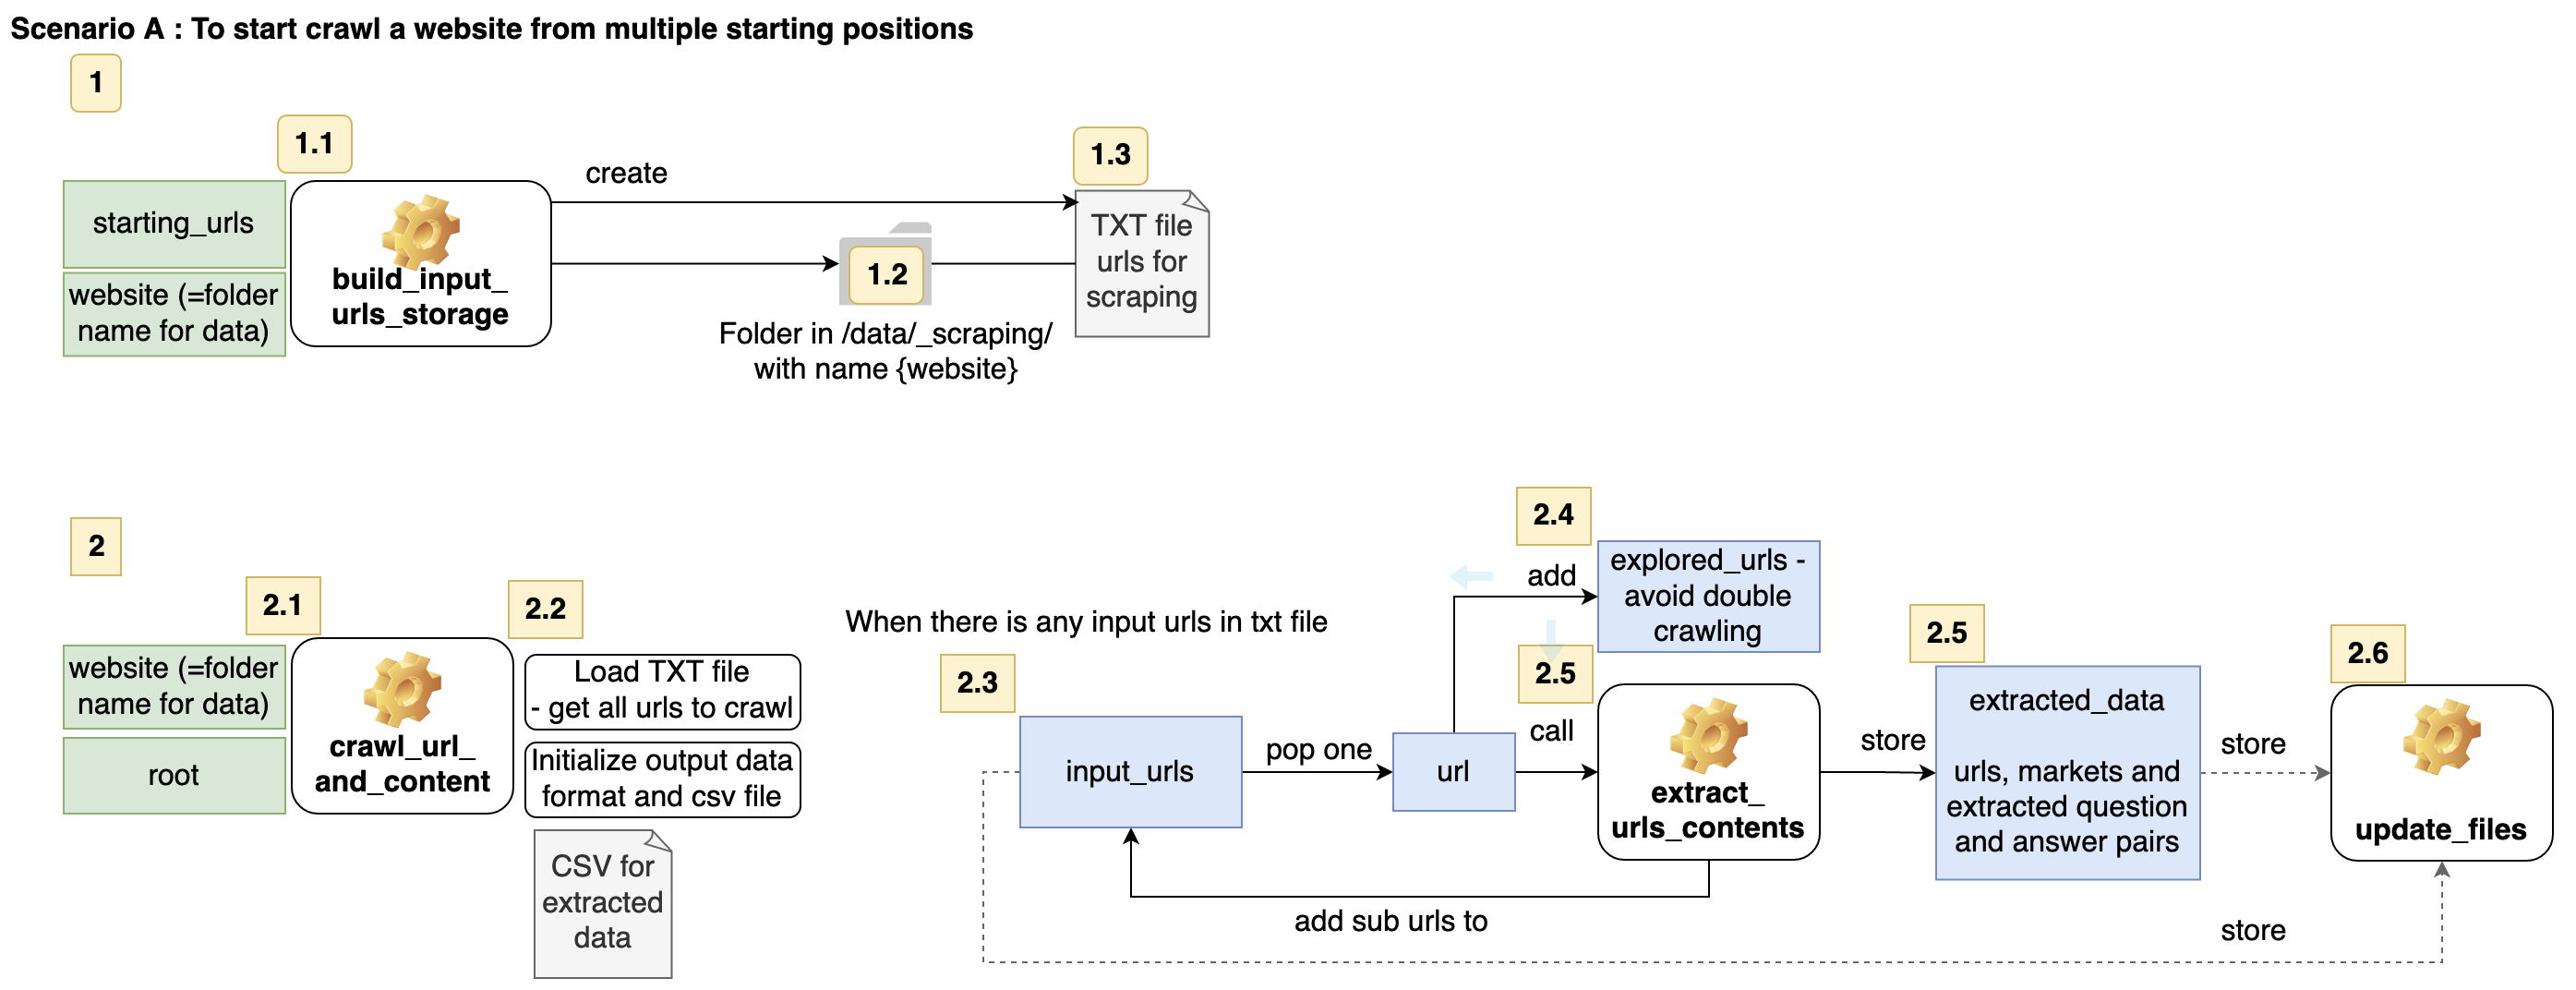

### Scenario B : To continue crawl a website that we have already crawled before
- 3.1. Call the module ```crawl_url_and_content``` with root and website name that we have already worked on (the website name should be a folder name in /data/_scrapping)
- 3.2. Load urls to crawl in existing txt file and initialize dictionary. Then, load the csv file with name _extracted_data.csv_ to get urls that we have alread processed and put in a set _explored_url_
- 3.3 - end: same step as 2.4 to 2.7

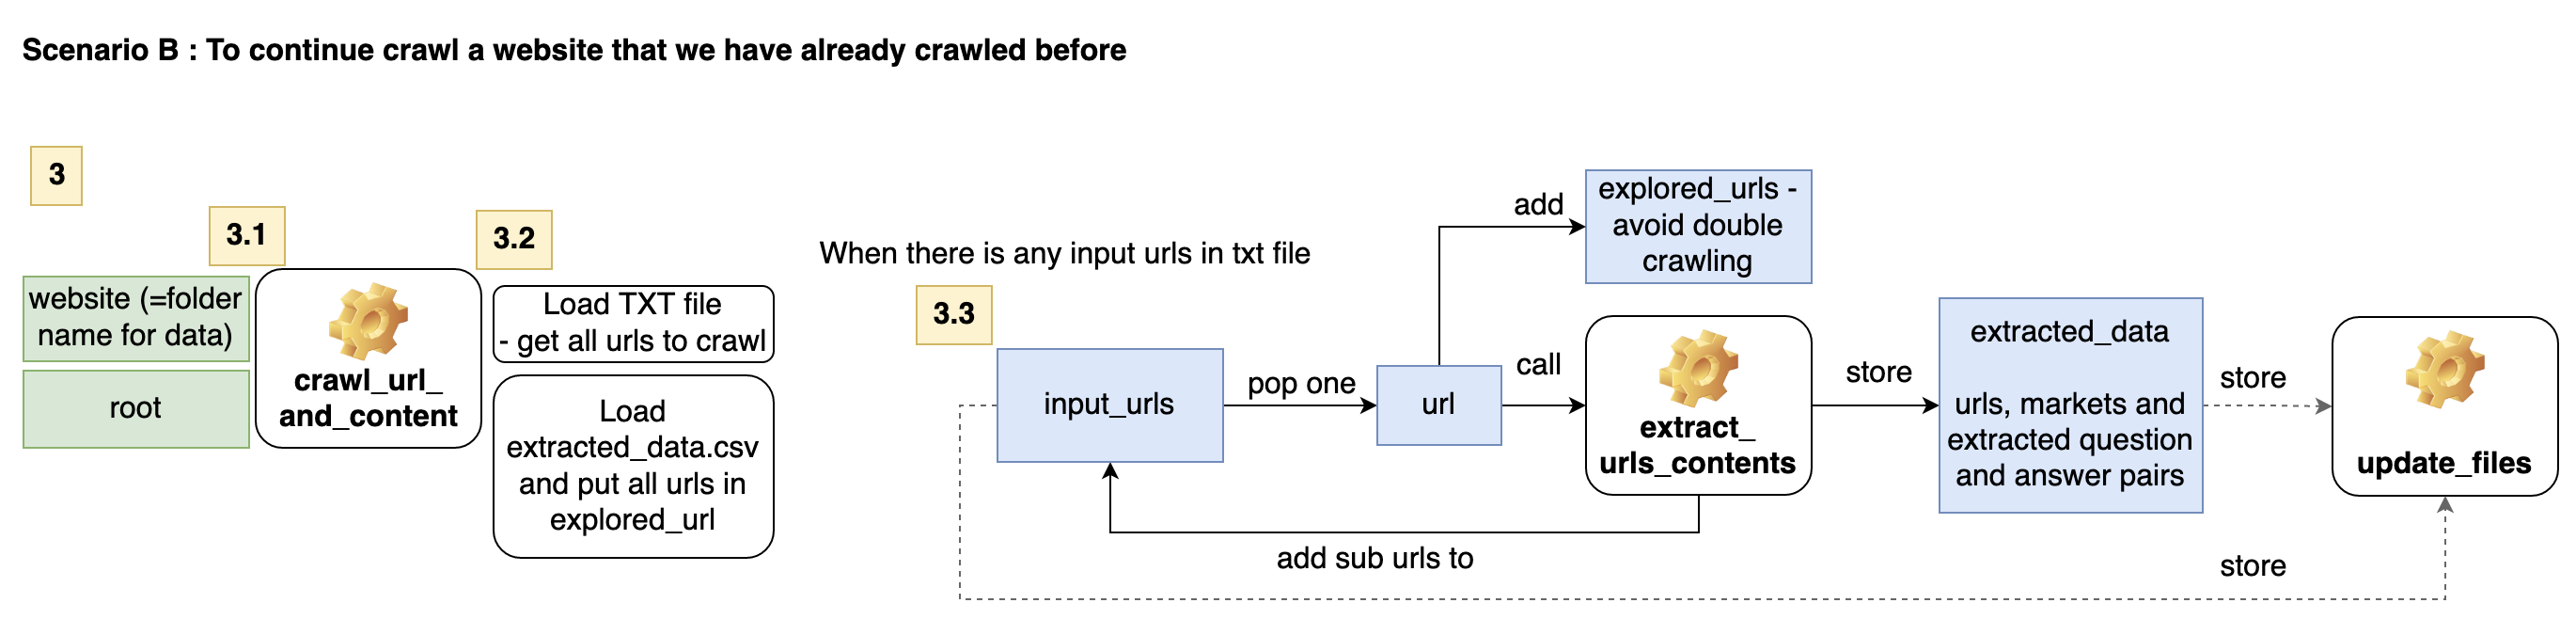

## Modules

In [3]:
def build_input_urls_storage(starting_urls, website):
    """
    Create a file to store urls to crawl. 
    Warnings: it will overwrite the file under /{website} with identical name.
    -------------------------
    Args:
        starting_urls (list): A list of urls as starting points
        website (str): The name of folder to store data

    Returns:
        None.
        And a file named input_urls.txt generated under folder data/{website}/
    """
    
    # Create folder if not exist
    output_folder = f'../data/_scraping/{website}/'
    if not os.path.isdir(output_folder):
        os.makedirs(output_folder)
    
    # Create txt file and add urls into it
    with open(f'../data/_scraping/{website}/input_urls.txt', "w") as f:
        for url in starting_urls:
            f.write(url+'\n')

In [ ]:
def extract_urls_contents(url):
    """
    Extract urls and question-answers in a given webpage (url)
    -------------------------
    Args:
        url (str): The webpage that we want to extract information

    Returns:
        sub_urls (set): a set (unique list) of urls found in the given webpage
        title: the question extracted from the given webpage
        content: the answer to the question
    """
    
    # Get the page content
    reqs = requests.get(url)
    soup = BeautifulSoup(reqs.text, 'html.parser')

    # Extract all sub urls
    sub_urls = set([link.get('href') for link in soup.find_all('a')])

    # Extract the question and answer pairs from a scraped content
    try:
        # Question and answer are stored in "div" section with "id=main"
        qnas = soup.find("div", {"id": "main"})
        title = qnas.find('h1').text.strip()
        content = qnas.text.replace(title, '')
    except:
        # If not found, set title as empty for further verification
        title = ''
        content = soup.text
    
    # Clean up the text
    content = re.sub("\n+", "\n", content)
    content = re.sub(" +", " ", content).strip()
    return sub_urls, title, content

In [ ]:
def update_files(extracted_data, output_path, input_urls, input_urls_path):
    """
    Update txt and csv files with new urls for scraping and scraped data
    -------------------------
    Args:
        extracted_data (dict): a dictionary with scraped url, market, and extracted question-answer pairs
        output_path (str): path to the csv file
        input_urls (str): urls for scraping to be added in the txt file
        input_urls_path (str): path to the txt file

    Returns:
        sub_urls (set): a set (unique list) of urls found in the given webpage
        title: the question extracted from the given webpage
        content: the answer to the question
    """
    
    # Store results in csv by adding data at the end of the file
    extracted_df = pd.DataFrame(extracted_data)
    extracted_df.to_csv(output_path, encoding='utf-8', mode='a', header=False, index=False)
    extracted_data = {"market":[], "url":[], "title":[], 'content':[]} # reset to empty for next round

    # Rewrite the txt file with url to crawl
    with open(input_urls_path, "w") as f:
        for url in input_urls:
            f.write(url+'\n')
    return extracted_data

In [6]:
def crawl_url_and_content(root, website):
    """
    Crawls a website from multiple starting positions 
    and retrieves all urls that start with the root field
    -------------------------
    Args:
        root (str): Only keep urls that start with this root
        website (str): The name of folder to store data

    Returns:
        output_path: path to parsed with all applicable urls, markets and scraped content
    """
    
    # Get stored input_urls and put in set to avoid duplication
    input_urls_path = f'../data/_scraping/{website}/input_urls.txt'
    with open(input_urls_path, "r") as f:
        input_urls = set([url for url in f.read().split('\n') if url != ''])
    
    # Get stored file or initialize output file
    # Get explored urls from file
    extracted_data = {"market":[], "url":[], "title":[], 'content':[]}
    output_path = f'../data/_scraping/{website}/extracted_data.csv'
    explored_urls = set()
    try:
        df = pd.read_csv(output_path, encoding='utf-8')
        explored_urls = set(df["url"].unique())
    except:
        df = pd.DataFrame(extracted_data)
        df.to_csv(output_path, encoding='utf-8', index=False)
    
    # update files every 10 results
    count = 0
    
    # When there is any url to crawl
    while input_urls:
        # Take a link off from list
        url = input_urls.pop()
        
        # Get the related geography-locale pair from link
        market = url.replace(root, '').split('/')[1]
        
        # Add to outputs
        explored_urls.add(url)

        sub_urls, title, content = extract_urls_contents(url)
        
        # Verify sub_urls is start with root field
        sub_urls = set([urljoin(root, link) for link in sub_urls if link and link.startswith('/'+market)])
        input_urls.update(sub_urls.difference(explored_urls))
        
        # Store in output file
        extracted_data["market"].append(market)
        extracted_data["url"].append(url)
        extracted_data["title"].append(title)
        extracted_data["content"].append(content)
        
        # update files every 10 results
        count += 1
        if count == 30:
            extracted_data = update_files(extracted_data, output_path, input_urls, input_urls_path)
            count = 0
    
    extracted_data = update_files(extracted_data, output_path, input_urls, input_urls_path)
    return output_path

## Run the program

In [ ]:
website = 'n26'
root='https://support.n26.com'

starting_urls = ['https://support.n26.com/de-de',
                 'https://support.n26.com/de-at',
                 'https://support.n26.com/en-at',
                 'https://support.n26.com/en-de',
                 'https://support.n26.com/en-it',
                 'https://support.n26.com/it-it',
                 'https://support.n26.com/en-eu',
                 'https://support.n26.com/en-fr',
                 'https://support.n26.com/fr-fr',
                 'https://support.n26.com/en-es',
                 'https://support.n26.com/es-es',
                 'https://support.n26.com/en-us',
                 'https://support.n26.com/en-gb'
                ]

In [7]:
%%time
build_input_urls_storage(starting_urls, website=website)
parsed_data_path = crawl_url_and_content(root=root, website=website)

CPU times: user 1min 42s, sys: 7.5 s, total: 1min 49s
Wall time: 57min 40s


## Process final extracted data
I decided to process data after craling all the urls as it is important to verify before removing and deleting data. 

### Load the data

In [16]:
extracted_df = pd.read_csv(parsed_data_path)

###  Review rows with empty title. This means that there wasn't any 'div' with 'id=main' in the given url.

It is clear that url with empty title don't have question and answer information.

In [19]:
extracted_df[extracted_df['title'].isnull()].head()

,market,url,title,content
0,es-es,https://support.n26.com/es-es,NaN,\nN26 Support | N26 Centro de Ayuda\nMenú prin...
2,en-de,https://support.n26.com/en-de,NaN,\nN26 Support | N26 Support DE\nMain navigatio...
8,en-eu,https://support.n26.com/en-eu,NaN,\nN26 Support | N26 Support EU\nMain navigatio...
48,en-it,https://support.n26.com/en-it,NaN,\nN26 Support | N26 Support IT\nMain navigatio...
56,it-it,https://support.n26.com/it-it,NaN,\nN26 Support | N26 Supporto Clienti\nNavigazi...


### Review url with character "#". # usually separates the anchor from the page itself. 
The url with # symbol refers to a particular section in the page but not questions.

In [20]:
extracted_df[extracted_df['url'].str.contains("#")].head()

,market,url,title,content
4,es-es,https://support.n26.com/es-es/pagos-transferen...,"Pagos, transferencias y retiradas",Retiradas de efectivo ¿Por qué no me ha dado d...
5,en-de,https://support.n26.com/en-de/cards#order-and-...,Cards,Order & DeliveryHow to reorder a card? When wi...
11,en-de,https://support.n26.com/en-de/app-and-features...,App & Features,MoneyBeamHow to use Moneybeam?Why can’t I see ...
15,es-es,https://support.n26.com/es-es/cuenta-e-informa...,Cuenta e información personal,Abrir una cuenta¿Puedo abrir una cuenta N26 e...
18,es-es,https://support.n26.com/es-es/tipos-de-cuenta-...,Tipos de cuenta y suscripciones,Cuentas Estándar¿Cuánto cuesta una cuenta N26?...


### Review url with different hierarchy

Urls with 2 hierarchy don't contain question-answer pair

In [26]:
extracted_df["section"] = extracted_df["url"].apply(lambda x: x.replace(root, '').split('/'))
extracted_df["nb_section"] = extracted_df["section"].apply(lambda x: len(x))

In [36]:
for link in extracted_df[extracted_df['nb_section']==4]["url"][:10]:
    print(link)

https://support.n26.com/en-de/cards/order-and-delivery/when-will-my-card-arrive
https://support.n26.com/es-es/pagos-transferencias-y-retiradas/domiciliaciones-y-transferencias-programadas/se-efectuara-mi-domiciliacion-si-tengo-pocos-fondos
https://support.n26.com/es-es/pagos-transferencias-y-retiradas/domiciliaciones-y-transferencias-programadas/por-que-me-han-cobrado-por-una-domiciliacion
https://support.n26.com/en-eu/account-and-personal-details/personal-information-and-data/how-can-i-change-my-phone-number-address-or-other-personal-data
https://support.n26.com/en-de/cards/setup-and-usage/how-to-block-contactless-payments-on-my-card
https://support.n26.com/en-eu/app-and-features/moneybeam/why-cant-i-see-other-n26-users-on-moneybeam
https://support.n26.com/en-de/app-and-features/app/how-to-revoke-my-consent-to-be-visible-as-an-n26-user
https://support.n26.com/es-es/pagos-transferencias-y-retiradas/pagos-con-tarjeta-y-por-internet/como-funcionan-los-pagos-contactless
https://support.n2

In [37]:
for link in extracted_df[extracted_df['nb_section']==3]["url"][:10]:
    print(link)

https://support.n26.com/it-it/article/3HvLAEnYr8wQDVxkmUhnmt
https://support.n26.com/en-de/article/4eMoEDm6RGEhlqkwKgnMcJ
https://support.n26.com/de-de/article/4eMoEDm6RGEhlqkwKgnMcJ
https://support.n26.com/en-it/article/3HvLAEnYr8wQDVxkmUhnmt
https://support.n26.com/es-es/article/2G7Q6IVREAYOKgG0eUSo06
https://support.n26.com/en-de/article/2G7Q6IVREAYOKgG0eUSo06
https://support.n26.com/de-de/article/2G7Q6IVREAYOKgG0eUSo06
https://support.n26.com/fr-fr/article/2G7Q6IVREAYOKgG0eUSo06
https://support.n26.com/en-eu/article/2G7Q6IVREAYOKgG0eUSo06
https://support.n26.com/it-it/article/2G7Q6IVREAYOKgG0eUSo06


In [38]:
for link in extracted_df[extracted_df['nb_section']==2]["url"][:10]:
    print(link)

https://support.n26.com/es-es/pagos-transferencias-y-retiradas
https://support.n26.com/en-de/cards
https://support.n26.com/en-eu/app-and-features
https://support.n26.com/de-at/sicherheit
https://support.n26.com/es-es/seguridad
https://support.n26.com/en-it/cards
https://support.n26.com/de-de/karten
https://support.n26.com/en-de/account-and-personal-details
https://support.n26.com/en-de/payments-transfers-and-withdrawals
https://support.n26.com/en-de/security


### Final Processing Model
Create a new csv under /data folder

In [55]:
extracted_df = pd.read_csv(parsed_data_path)

extracted_df["nb_section"] = extracted_df["url"].apply(lambda x: len(x.replace(root, '').split('/')))

extracted_df = extracted_df[extracted_df['title'].notnull()]
extracted_df = extracted_df[~(extracted_df['url'].str.contains("#"))]
extracted_df = extracted_df[extracted_df['nb_section']!=2]

In [56]:
extracted_df = extracted_df.drop('nb_section', axis=1).reset_index(drop=True)

In [58]:
extracted_df.to_csv(f'../data/extracted_{website}.csv')

**The scrapping works pretty well. Let's go to next step.**